In [1]:
import time
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from quantum.Quantum import QuantumRegressor
from quantum.Circuits import double_angle, entangle_cnot, mitarai, single_angle, rotation_layer, entangle_cz, composer
from quantum.Evaluate import evaluate_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
st = time.time()
# Generate random data
np.random.seed(4)  # Set seed for reproducibility
X = np.random.uniform(low=0, high=10, size=(100,))
y = np.sin(X / 2)

# Reshape X to (-1, 1)
X = X.reshape(-1, 1)

# Normalize the dataset between -1 and 1
scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


## Here we define all of the encoders we will use

Listing encoders to be used and compared i this notebook. This list is derived from Suzuki & Katouda DOI 10.1088/2399-6528/abd3d8

In [3]:
encoders = {
    'M': mitarai,
    'A1': single_angle,
    'A2': double_angle,
    'M-M-CNOT': composer(mitarai, entangle_cnot, mitarai, entangle_cnot),
    'A1-A1-CNOT': composer(single_angle, entangle_cnot, single_angle, entangle_cnot),
    'A2-A2-CNOT': composer(double_angle, entangle_cnot, double_angle, entangle_cnot),
    'M-A1-CNOT': composer(mitarai, entangle_cnot, single_angle, entangle_cnot), 
    'M-A2-CNOT': composer(mitarai, entangle_cnot, double_angle entangle_cnot),
    'M-M-CZ': composer(mitarai, entangle_cz, mitarai, entangle_cz),
    'A1-A1-CZ': composer(single_angle, entangle_cz, single_angle, entangle_cz),
    'A2-A2-CZ': composer(double_angle, entangle_cz, double_angle, entangle_cz),
    'M-A1-CZ': composer(mitarai, entangle_cz, single_angle, entangle_cz),
    'M-A2-CZ': composer(mitarai, entangle_cz, double_angle, entangle_cz)
}


## Model training

Here we define the parameters of our model and a random set of initial parameters. Then we loop through each of the encoders and train the model for them and evaluate/plot it.

Starting on: M encoder...

Training completed 
 taking  962.8234348297119 seconds
Starting on: A1 encoder...

Training completed 
 taking  977.3178386688232 seconds
Starting on: A2 encoder...

Training completed 
 taking  456.48261523246765 seconds
Starting on: M-M-CNOT encoder...



capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/taylo773/miniconda3/envs/qregress/lib/python3.10/site-packages/pennylane/qnode.py", line 590, in get_best_method
    return QNode._validate_device_method(device)
  File "/home/taylo773/miniconda3/envs/qregress/lib/python3.10/site-packages/pennylane/qnode.py", line 723, in _validate_device_method
    raise qml.QuantumFunctionError(
pennylane.QuantumFunctionError: The default.qubit device does not provide a native method for computing the jacobian.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/taylo773/miniconda3/envs/qregress/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10689/4011193659.py", line 21, in <module>
    opt_results = model.fit(X_train, y_train, initial_parameters, detailed_results=True)
  File "/home/taylo773/Quantum/GitHub/qregress/quan

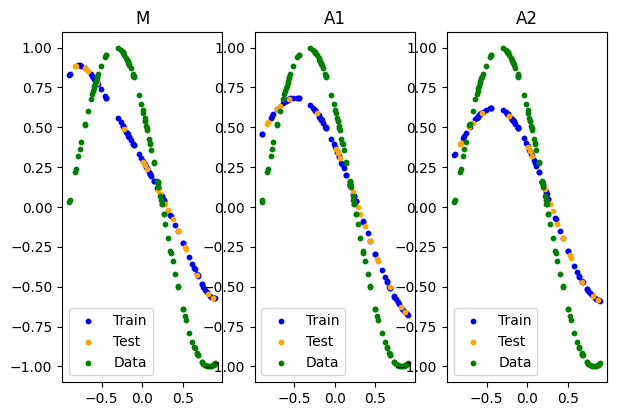

In [5]:
num_qubits = 3
layers = 3
initial_parameters = np.random.uniform(low=-1, high=1, size= 3 * 2 * num_qubits)
def variational(parameters, wires):
    num_qubits = len(wires)
    rotation_layer(parameters[:num_qubits *3], wires)
    entangle_cnot(wires)
    rotation_layer(parameters[num_qubits *3:num_qubits*3 *2], wires)
        
results = {}

fig = plt.figure(figsize=(12, 2*5), dpi=100)
n_cols = 5
n_rows = int(len(list(encoders.keys())) / n_cols) + 1
i=0

for name, encoder in encoders.items():
    print('Starting on:', name, 'encoder...\n')
    st = time.time()
    model = QuantumRegressor(encoder, variational, num_qubits)
    opt_results = model.fit(X_train, y_train, initial_parameters, detailed_results=True)
    et = time.time()
    print('Training completed taking ', et-st, 'seconds\n')
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    loss = evaluate_model(model, X_train, X_test, y_train, y_test, title=name)
    i += 1
    results[name] = [opt_results, loss]
plt.tight_layout()